## 数据集Dataloader制作

### 如何自定义数据集：

- 1.数据和标签的目录结构先搞定(得知道到哪读数据)
- 2.写好读取数据和标签路径的函数(根据自己数据集情况来写)
- 3.完成单个数据与标签读取函数(给dataloader举一个例子)

### 咱们以花朵数据集为例：

- 原来数据集都是以文件夹为类别ID，现在咱们换一个套路，用txt文件指定数据路径与标签(实际情况基本都这样)
- 这回咱们的任务就是在txt文件中获取图像路径与标签，然后把他们交给dataloader
- 核心代码非常简单，按照对应格式传递需要的数据和标签就可以啦

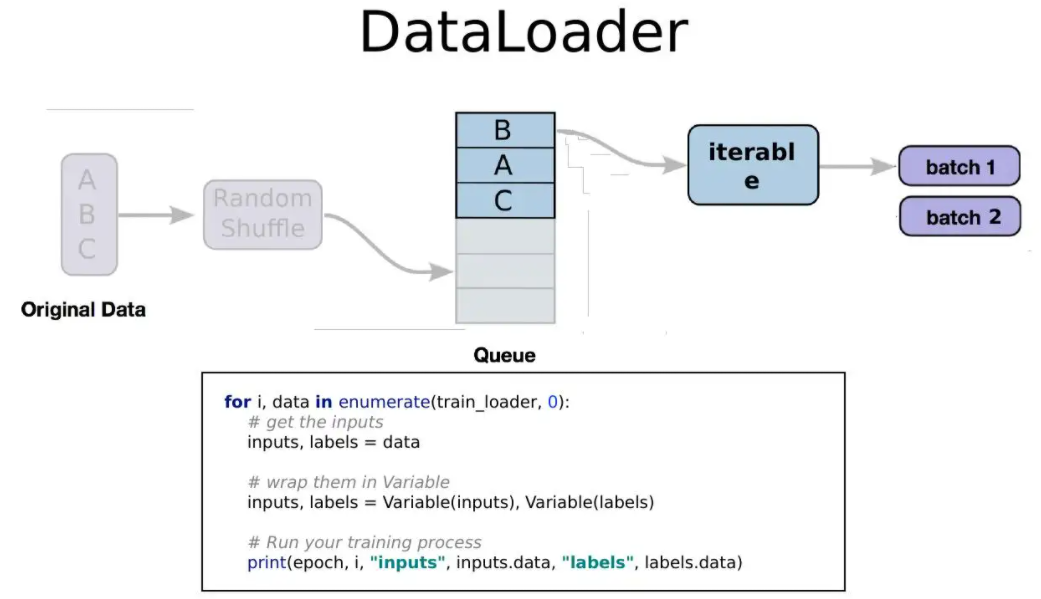

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
#https://pytorch.org/docs/stable/torchvision/index.html
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

## 先来分细节整明白咱一会要干啥！

#### 任务1：读取txt文件中的路径和标签

- 第一个小任务，从标注文件中读取数据和标签
- 至于你准备存成什么格式，都可以的，一会能取出来东西就行

In [2]:
with open('./flower_data/train.txt') as f:
    samples = [x.strip().split(' ') for x in f.readlines()]
    print(samples)

[['image_06734.jpg', '0'], ['image_06735.jpg', '0'], ['image_06736.jpg', '0'], ['image_06737.jpg', '0'], ['image_06738.jpg', '0'], ['image_06740.jpg', '0'], ['image_06741.jpg', '0'], ['image_06742.jpg', '0'], ['image_06744.jpg', '0'], ['image_06745.jpg', '0'], ['image_06746.jpg', '0'], ['image_06747.jpg', '0'], ['image_06748.jpg', '0'], ['image_06750.jpg', '0'], ['image_06751.jpg', '0'], ['image_06753.jpg', '0'], ['image_06757.jpg', '0'], ['image_06759.jpg', '0'], ['image_06761.jpg', '0'], ['image_06762.jpg', '0'], ['image_06766.jpg', '0'], ['image_06767.jpg', '0'], ['image_06768.jpg', '0'], ['image_06770.jpg', '0'], ['image_06771.jpg', '0'], ['image_06772.jpg', '0'], ['image_06773.jpg', '0'], ['image_07086.jpg', '9'], ['image_07087.jpg', '9'], ['image_07088.jpg', '9'], ['image_07089.jpg', '9'], ['image_07091.jpg', '9'], ['image_07092.jpg', '9'], ['image_07093.jpg', '9'], ['image_07095.jpg', '9'], ['image_07096.jpg', '9'], ['image_07097.jpg', '9'], ['image_07098.jpg', '9'], ['image_070

In [3]:
def load_annotations(ann_file):
    data_infos = {}
    with open(ann_file) as f:
        # strip() 去掉换行符
        samples = [x.strip().split(' ') for x in f.readlines()]
        for filename, gt_label in samples:
            data_infos[filename] = np.array(gt_label, dtype=np.int64)
    return data_infos

In [4]:
print(load_annotations('./flower_data/train.txt'))

{'image_06734.jpg': array(0, dtype=int64), 'image_06735.jpg': array(0, dtype=int64), 'image_06736.jpg': array(0, dtype=int64), 'image_06737.jpg': array(0, dtype=int64), 'image_06738.jpg': array(0, dtype=int64), 'image_06740.jpg': array(0, dtype=int64), 'image_06741.jpg': array(0, dtype=int64), 'image_06742.jpg': array(0, dtype=int64), 'image_06744.jpg': array(0, dtype=int64), 'image_06745.jpg': array(0, dtype=int64), 'image_06746.jpg': array(0, dtype=int64), 'image_06747.jpg': array(0, dtype=int64), 'image_06748.jpg': array(0, dtype=int64), 'image_06750.jpg': array(0, dtype=int64), 'image_06751.jpg': array(0, dtype=int64), 'image_06753.jpg': array(0, dtype=int64), 'image_06757.jpg': array(0, dtype=int64), 'image_06759.jpg': array(0, dtype=int64), 'image_06761.jpg': array(0, dtype=int64), 'image_06762.jpg': array(0, dtype=int64), 'image_06766.jpg': array(0, dtype=int64), 'image_06767.jpg': array(0, dtype=int64), 'image_06768.jpg': array(0, dtype=int64), 'image_06770.jpg': array(0, dtype

#### 任务2：分别把数据和标签都存在list里

- 不是我非让你存list里，因为dataloader到时候会在这里取数据
- 按照人家要求来，不要耍个性，让整list咱就给人家整

In [5]:
img_label = load_annotations('./flower_data/train.txt')

In [6]:
image_name = list(img_label.keys())
label = list(img_label.values())

In [7]:
image_name

['image_06734.jpg',
 'image_06735.jpg',
 'image_06736.jpg',
 'image_06737.jpg',
 'image_06738.jpg',
 'image_06740.jpg',
 'image_06741.jpg',
 'image_06742.jpg',
 'image_06744.jpg',
 'image_06745.jpg',
 'image_06746.jpg',
 'image_06747.jpg',
 'image_06748.jpg',
 'image_06750.jpg',
 'image_06751.jpg',
 'image_06753.jpg',
 'image_06757.jpg',
 'image_06759.jpg',
 'image_06761.jpg',
 'image_06762.jpg',
 'image_06766.jpg',
 'image_06767.jpg',
 'image_06768.jpg',
 'image_06770.jpg',
 'image_06771.jpg',
 'image_06772.jpg',
 'image_06773.jpg',
 'image_07086.jpg',
 'image_07087.jpg',
 'image_07088.jpg',
 'image_07089.jpg',
 'image_07091.jpg',
 'image_07092.jpg',
 'image_07093.jpg',
 'image_07095.jpg',
 'image_07096.jpg',
 'image_07097.jpg',
 'image_07098.jpg',
 'image_07099.jpg',
 'image_07100.jpg',
 'image_07103.jpg',
 'image_07105.jpg',
 'image_07106.jpg',
 'image_07108.jpg',
 'image_07109.jpg',
 'image_07110.jpg',
 'image_07111.jpg',
 'image_07112.jpg',
 'image_07113.jpg',
 'image_07114.jpg',


In [8]:
label

[array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=int64),
 array(9, dtype=

#### 任务3：图像数据路径得完整

- 因为一会咱得用这个路径去读数据，所以路径得加上前缀
- 以后大家任务不同，数据不同，怎么加你看着来就行，反正得能读到图像

In [9]:
data_dir = './flower_data/'
train_dir = data_dir + '/train_filelist'
valid_dir = data_dir + '/val_filelist'

In [10]:
image_path = [os.path.join(train_dir,img) for img in image_name]
image_path

['./flower_data//train_filelist\\image_06734.jpg',
 './flower_data//train_filelist\\image_06735.jpg',
 './flower_data//train_filelist\\image_06736.jpg',
 './flower_data//train_filelist\\image_06737.jpg',
 './flower_data//train_filelist\\image_06738.jpg',
 './flower_data//train_filelist\\image_06740.jpg',
 './flower_data//train_filelist\\image_06741.jpg',
 './flower_data//train_filelist\\image_06742.jpg',
 './flower_data//train_filelist\\image_06744.jpg',
 './flower_data//train_filelist\\image_06745.jpg',
 './flower_data//train_filelist\\image_06746.jpg',
 './flower_data//train_filelist\\image_06747.jpg',
 './flower_data//train_filelist\\image_06748.jpg',
 './flower_data//train_filelist\\image_06750.jpg',
 './flower_data//train_filelist\\image_06751.jpg',
 './flower_data//train_filelist\\image_06753.jpg',
 './flower_data//train_filelist\\image_06757.jpg',
 './flower_data//train_filelist\\image_06759.jpg',
 './flower_data//train_filelist\\image_06761.jpg',
 './flower_data//train_filelist

#### 任务4：把上面那几个事得写在一起

- 1.注意要使用from torch.utils.data import Dataset, DataLoader
- 2.类名定义class FlowerDataset(Dataset)，其中FlowerDataset可以改成自己的名字
- 3.def __init__(self, root_dir, ann_file, transform=None):咱们要根据自己任务重写
- 4.def __getitem__(self, idx):根据自己任务，返回图像数据和标签数据

In [11]:
from torch.utils.data import Dataset, DataLoader
class FlowerDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        # 标签文件路径
        self.ann_file = ann_file
        # 当前所在文件夹的路径
        self.root_dir = root_dir
        self.img_label = self.load_annotations()
        # 拿到所有图片 完整路径 的列表
        self.img = [os.path.join(self.root_dir,img) for img in list(self.img_label.keys())]
        # 拿到所有图片 标签的列表
        self.label = [label for label in list(self.img_label.values())]
        # transform进行预处理
        self.transform = transform
 
    def __len__(self):
        return len(self.img)

    '''
    idx是下标，通过它可以拿到图像路径和标签数据，每次调用__getitem__，idx都是不同的
    调用一次getitem就生成一张图片的图片信息和对应的标签
    此时我们定义的__getitem__是在DataLoader内部定义的，实际调用DataLoader时，外部会传入batch_num的大小，然后DataLoader会调用 __getitem__方法batch_num次，最后打包好
    假如batch_num=64，最后返回的结果：image：64x3x256x256。label：64x1
    '''
    def __getitem__(self, idx):
        # 通过Image拿到具体的图片数据
        image = Image.open(self.img[idx])
        # 拿到图片对应的标签信息
        label = self.label[idx]
        # 预处理（这里只预处理了image，没有预处理标签。在检测任务中，标签也是需要预处理的。）
        # transform方法中，已经将image转换为tensor格式了
        if self.transform:
            image = self.transform(image)
        # 将标签label从numpy格式转为tensor格式 
        label = torch.from_numpy(np.array(label))
        # 举例最后返回的image：3x256x256。label：1
        return image, label
    def load_annotations(self):
        data_infos = {}
        with open(self.ann_file) as f:
            samples = [x.strip().split(' ') for x in f.readlines()]
            for filename, gt_label in samples:
                data_infos[filename] = np.array(gt_label, dtype=np.int64)
        return data_infos

#### 任务5：数据预处理(transform)

- 1.预处理的事都在上面的__getitem__中完成，需要对图像和标签咋咋地的，要整啥事，都在上面整
- 2.返回的数据和标签就是建模时模型的输入和损失函数中标签的输入，一定整明白自己模型要啥
- 3.预处理这个事是你定的，不同的数据需要的方法也不一样，下面给出的是比较通用的方法

In [12]:
data_transforms = {
    'train': 
        transforms.Compose([
        transforms.Resize(64),
        transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(64),#从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差（标准化）
    ]),
    'valid': 
        transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### 任务6：根据写好的class FlowerDataset(Dataset):来实例化咱们的dataloader

- 1.构建数据集：分别创建训练和验证用的数据集（如果需要测试集也一样的方法）
- 2.用Torch给的DataLoader方法来实例化(batch啥的自己定，根据你的显存来选合适的)
- 3.打印看看数据里面是不是有东西了

In [13]:
# 构建训练集
train_dataset = FlowerDataset(root_dir=train_dir, ann_file = './flower_data/train.txt', transform=data_transforms['train'])

In [14]:
# 构建验证集
val_dataset = FlowerDataset(root_dir=valid_dir, ann_file = './flower_data/val.txt', transform=data_transforms['valid'])

In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [16]:
len(train_dataset)

6552

In [17]:
len(val_dataset)

818

#### 任务7：用之前先试试，整个数据和标签对应下，看看对不对

- 1.别着急往模型里传，对不对都不知道呢
- 2.用这个方法：iter(train_loader).next()来试试，得到的数据和标签是啥
- 3.看不出来就把图画出来，标签打印出来，确保自己整的数据集没啥问题

In [33]:
image, label = next(iter(train_loader))
print(image.shape, label, len(label))

torch.Size([64, 3, 64, 64]) tensor([12, 29, 72, 42, 71, 55, 55, 46, 94, 94, 16, 68, 74, 73, 41, 55, 70, 63,
        50, 77,  0, 48, 45, 41, 94, 34, 84, 49, 39, 17, 99, 68, 70, 83, 14, 59,
        73, 82, 88, 44, 60, 18, 91, 48, 42, 36, 10, 90, 64, 40,  6, 12, 80, 15,
        75, 72, 81,  1, 61, 95, 74, 44,  1, 28]) 64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4305114e-08..0.9764706].


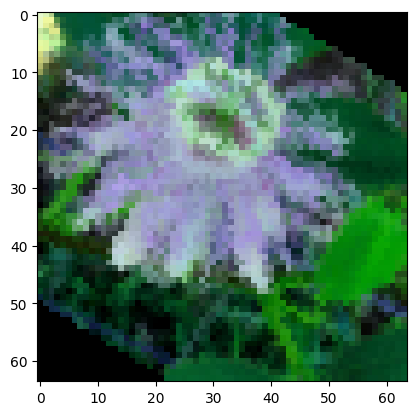

Label is: 76


In [31]:
image, label = next(iter(train_loader))
# squeeze()对图片数据中，维度为1的进行压缩
sample = image[0].squeeze()
# permute把图片的维度顺序换下位置
sample = sample.permute((1, 2, 0)).numpy()
# 由于在预处理的时候，我们比上了标准差，减去了均值，所以展示图片时需要把数据还原
sample *= [0.229, 0.224, 0.225]
sample += [0.485, 0.456, 0.406]
plt.imshow(sample)
plt.show()
print('Label is: {}'.format(label[0].numpy()))

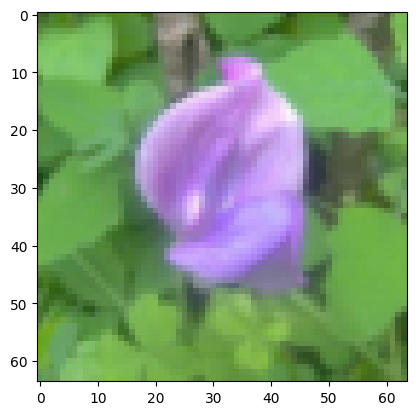

Label is: 3


In [34]:
image, label = next(iter(val_loader))
sample = image[0].squeeze()
sample = sample.permute((1, 2, 0)).numpy()
sample *= [0.229, 0.224, 0.225]
sample += [0.485, 0.456, 0.406]
plt.imshow(sample)
plt.show()
print('Label is: {}'.format(label[0].numpy()))

#### 任务8：咋用就是你来定了，把模型啥的整好往里面传吧

- 下面这些事之前都唠过了，按照自己习惯的方法整就得了

In [57]:
dataloaders = {'train':train_loader,'valid':val_loader}

In [58]:
model_name = 'resnet'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
#是否用人家训练好的特征来做
feature_extract = True 

In [59]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is not available.  Training on CPU ...


In [60]:
model_ft = models.resnet18()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 102))
input_size = 64
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
# 优化器设置
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
criterion = nn.CrossEntropyLoss()

In [63]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, filename='best.pth'):
    since = time.time()
    best_acc = 0
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    #print(loss)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),#优化器的状态信息
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)#学习率衰减
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

In [ ]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20, filename='best.pth')

Epoch 0/19
----------
Time elapsed 2m 45s
train Loss: 3.9809 Acc: 0.0917
Time elapsed 2m 55s
valid Loss: 3.8689 Acc: 0.1259
Optimizer learning rate : 0.0010000

Epoch 1/19
----------


D:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
